In [1]:
import os
import glob
import time
import copy

import torch
import torchvision
import torchsummary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {}".format(device))

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1
Using cpu


In [3]:
num_classes = 2

### Initialize input data transforms

In [4]:
# The pre-trained torch models expect input images normalized in the same way, 
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W
# are expected to be at least 224.
normalization_mean_std = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*normalization_mean_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(*normalization_mean_std)
    ]),
}

### Setup Datasets and Dataloaders

In [5]:
class SampleDataset(Dataset):
    def __init__(self, sample_dir, labels_path=None, transform=None):
        self.files = glob.glob(sample_dir + "/*.tif")
        self.transform = transform
        self.labels = None
        if labels_path:
            labels_df = pd.read_csv(labels_path)
            self.labels = dict(zip(labels_df.id, labels_df.label))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        image = Image.open(path)
        sample_id = os.path.basename(path)[:-len(".tif")]
        if self.transform:
            image = self.transform(image)
        sample = {'id': sample_id,
                  'image': image}
        if self.labels:
            sample['label'] = torch.tensor([1, 0] if self.labels[sample_id] == 0 else [0, 1], dtype=torch.float)
        return sample

    def pos_weight(self):
        if not self.labels:
            return torch.tensor(0.0)

        labels_in_dir = set([os.path.basename(i)[:-len(".tif")] for i in self.files])
        positive_labels_in_dir = [k for (k, v) in self.labels.items() if (v == 1 and k in labels_in_dir)]
        positive = len(positive_labels_in_dir)
        negative = len(labels_in_dir) - positive
        return torch.tensor([negative / positive if positive > 0 else 0])

## Training

In [6]:
dirnames = {'train': 'train_sub',
            'val': 'val_sub'}

transformed_datasets = {x: SampleDataset(labels_path = 'train_labels.csv',
                                         sample_dir = dirnames[x],
                                         transform = data_transforms[x]) for x in ['train', 'val']}

dataset_sizes = {x: len(transformed_datasets[x]) for x in ['train', 'val']}

print(transformed_datasets.keys())
dataloaders = {x: DataLoader(transformed_datasets[x],
                             batch_size=128,
                             shuffle=True, 
                             num_workers=4) for x in ['train', 'val']}
print(dataloaders.keys())

dict_keys(['train', 'val'])
dict_keys(['train', 'val'])


In [7]:
print(transformed_datasets['train'].pos_weight())
print(transformed_datasets['val'].pos_weight())

tensor([1.4673])
tensor([1.6000])


In [8]:
for i_batch, sample_batched in enumerate(dataloaders['train']):
    print(i_batch, 
          sample_batched['image'].size(),
          sample_batched['label'].size())
    if i_batch == 5:
        break

0 torch.Size([128, 3, 224, 224]) torch.Size([128, 2])
1 torch.Size([128, 3, 224, 224]) torch.Size([128, 2])
2 torch.Size([128, 3, 224, 224]) torch.Size([128, 2])
3 torch.Size([128, 3, 224, 224]) torch.Size([128, 2])
4 torch.Size([128, 3, 224, 224]) torch.Size([128, 2])
5 torch.Size([128, 3, 224, 224]) torch.Size([128, 2])


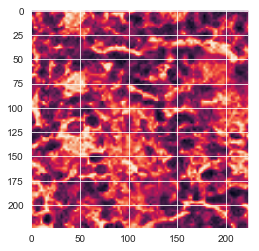

In [9]:
plt.imshow(np.transpose(transformed_datasets['train'][4]['image'],[2,1,0])[:,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


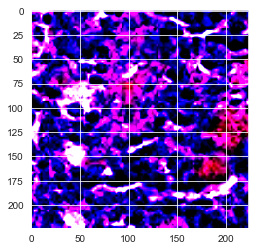

In [10]:
plt.imshow(np.transpose(transformed_datasets['train'][4]['image']))

In [13]:
def plot_results(losses, accuracies):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
    ax1.plot(np.squeeze(losses['train']), 'r', label='train')
    ax1.plot(np.squeeze(losses['val']), 'g', label='val')
    ax1.set_ylabel('loss', fontsize=14)
    ax1.set_xlabel('iterations (per tens)', fontsize=14)
    
    ax2.plot(np.squeeze(accuracies['train']), 'r', label='train')
    ax2.plot(np.squeeze(accuracies['val']), 'g', label='val')
    ax2.set_ylabel('accuracy', fontsize=14)
    ax2.set_xlabel('iterations (per tens)', fontsize=14)
    
    plt.show()
    
# plot_results({'train': [0.5, 0.4, 0.35, 0.3, 0.12], 'val': [1.5, 1.4, 0.35, 0.25, 0.1]},
#             {'train': [0.5, 0.4, 0.35, 0.3, 0.12], 'val': [1.5, 1.4, 0.35, 0.25, 0.1]})

In [14]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25, max_epochs_stop=3):
    """
    Trains for the specified number of epochs and after each epoch runs a full validation step.
    It keeps track of the best performing model (in terms of validation accuracy), and at the
    end of training returns the best performing model. After each epoch, the training and
    validation accuracies are printed.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    # Early stopping intialization
    epochs_no_improve = 0
    best_valid_loss = np.Inf
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device)
                labels = sample['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                flat_labels = torch.tensor([i[1] for i in labels.data], dtype=torch.long)
                running_corrects += torch.sum(preds == flat_labels)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    plot_results(losses, accuracies)
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Initialize pretrained model

In [15]:
model_ft = models.resnet18(pretrained=True)

# we are feature-extracting so let's set requires_grad to False
# we only want to compute gradients for the newly initialized layer 
# we want all of the other parameters to not require gradients
# for param in model_ft.parameters():
#     param.requires_grad = False

# reinitialize model.fc (final fully connected layer) to be a Linear layer
# with the same number of input features and 2 output features (classes)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# ResNet-18 is composed of 8 residual modules
# Freeze the first 6 modules
frozen = True
if frozen == True:
    child_counter = 0
    for child in model_ft.children():
        print("Child", child_counter)
        print(child)
        if child_counter < 6:
            print("Child", child_counter, "was frozen")
            for param in child.parameters():
                param.requires_grad = False
        print("-----")
        child_counter += 1
        
print()

print("Params to learn:")
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t", name)
        
model_ft = model_ft.to(device)

Child 0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child 0 was frozen
-----
Child 1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child 1 was frozen
-----
Child 2
ReLU(inplace)
Child 2 was frozen
-----
Child 3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child 3 was frozen
-----
Child 4
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [16]:
# Print full model summary
torchsummary.summary(model_ft,
        input_size=(3, 224, 224),
        batch_size=128,
        device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]          36,864
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
       BasicBlock-11          [128, 64, 56, 56]               0
           Conv2d-12          [128, 64, 56, 56]          36,864
      BatchNorm2d-13          [128, 64, 56, 56]             128
             ReLU-14          [128, 64,

### Criterion

In [17]:
criterion = nn.BCEWithLogitsLoss(pos_weight=transformed_datasets['train'].pos_weight())

### Optimizer

In [18]:
# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 0.6483 Acc: 0.7419
val Loss: 1.0174 Acc: 0.8462

Epoch 1/24
----------
train Loss: 0.3533 Acc: 0.8830
val Loss: 1.9915 Acc: 0.6731

Epoch 2/24
----------
train Loss: 0.1921 Acc: 0.9505
val Loss: 1.1934 Acc: 0.7404

Epoch 3/24
----------
train Loss: 0.0950 Acc: 0.9674
val Loss: 0.4138 Acc: 0.8654

Epoch 4/24
----------
train Loss: 0.0956 Acc: 0.9771
val Loss: 0.4950 Acc: 0.8269

Epoch 5/24
----------
train Loss: 0.0828 Acc: 0.9771
val Loss: 0.2578 Acc: 0.9231

Epoch 6/24
----------
train Loss: 0.0806 Acc: 0.9759
val Loss: 0.4748 Acc: 0.8654

Epoch 7/24
----------
train Loss: 0.0571 Acc: 0.9903
val Loss: 0.3057 Acc: 0.9038

Epoch 8/24
----------
train Loss: 0.0320 Acc: 0.9952
val Loss: 0.2801 Acc: 0.9038

Epoch 9/24
----------
train Loss: 0.0236 Acc: 0.9940
val Loss: 0.2997 Acc: 0.8846

Epoch 10/24
----------
train Loss: 0.0165 Acc: 0.9988
val Loss: 0.3251 Acc: 0.8846

Epoch 11/24
----------
train Loss: 0.0167 Acc: 0.9988
val Loss: 0.3435 Acc: 0.8750

Ep

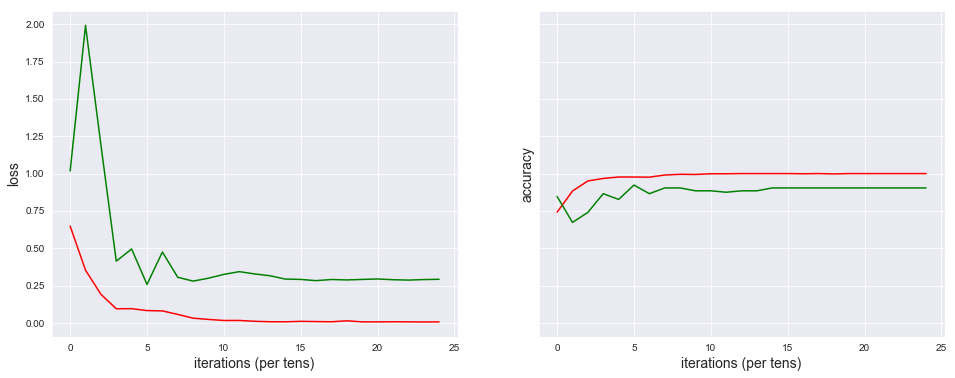

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       dataloaders, num_epochs=25)

In [20]:
# Persist latest model
torch.save(model_ft.state_dict(), "resnet18-last-two-layers-training-25-epochs.pth")

## Predict

In [ ]:
def predict(data_loader, model):
    since = time.time()
    model.eval()
    # if USE_GPU:
    #     model = model.cuda()

    ids = []
    predictions = []
    
    for i, sample in enumerate(data_loader):
        print(type(sample['id']))
#         X = sample['image'].to(device)
#         batch_ids = sample["id"]
#         print(len(ids))
# #         if USE_GPU:
# #             X = X.cuda()

#         ids.extend(batch_ids)

#         with torch.set_grad_enabled(False):
#             y_pred = model(X)
#             predictions.append((y_pred >= 0.5).float().cpu().numpy())

    time_elapsed = time.time() - since
    print('Prediction complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return ids, predictions

### Load test data

In [ ]:
test_data = SampleDataset(
    sample_dir = "test/",
    transform = data_transforms['val'])

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=25,
    shuffle=False,
    num_workers=4
)

### Load the trained model and run predictions

In [ ]:
# Load a new model and apply the trained weights

trained_model = models.resnet18()
num_ftrs = trained_model.fc.in_features
trained_model.fc = nn.Linear(num_ftrs, num_classes)
trained_model.load_state_dict(torch.load("resnet18-last-two-layers-training-25-epochs.pth"))

ids, predictions = predict(test_loader, trained_model)

In [ ]:
# print(predictions[0])
print(len(predictions))
x = np.concatenate(predictions).reshape(-1,).astype("int")
print(x[:10])

print(len(predictions))
# submissions = pd.DataFrame({
#     "id": ids_all,
#     "label": np.concatenate(predictions).reshape(-1,).astype("int")
# }).set_index("id")